In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Concatenate, Dense, Input, Lambda

from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Concatenate, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Rescale pixel values to [0, 1]
    rotation_range=20,         # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,     # Randomly shift images horizontally by up to 20% of width
    height_shift_range=0.2,    # Randomly shift images vertically by up to 20% of height
    shear_range=0.2,           # Apply random shear transformations
    zoom_range=0.2,            # Randomly zoom into images by up to 20%
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Fill in missing pixels with nearest pixel values
)

# Define ImageDataGenerator for validation data (no augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
# Set batch size
batch_size = 32

# Flow training images in batches using train_datagen
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/dataset 2000 image/archive (9) - Copy - Copy/Data/train',                 # Directory containing training images
    target_size=(224, 224),    # Resize images to match input size of VGG16
    batch_size=batch_size,     # Batch size
    class_mode='categorical'   # Specify categorical labels
)

# Flow validation images in batches using validation_datagen
validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/dataset 2000 image/archive (9) - Copy - Copy/Data/test',            # Directory containing validation images
    target_size=(224, 224),    # Resize images to match input size of VGG16
    batch_size=batch_size,     # Batch size
    class_mode='categorical'   # Specify categorical labels
)

Found 1447 images belonging to 3 classes.
Found 404 images belonging to 3 classes.


In [ ]:
# Load pre-trained models
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))



87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
# Freeze the convolutional layers of the base models
vgg_model.trainable = False
resnet_model.trainable = False
inception_model.trainable = False

In [ ]:
# Define input layer
input_layer = Input(shape=(224, 224, 3))

# Obtain outputs from each base model
vgg_output = vgg_model(input_layer)
resnet_output = resnet_model(input_layer)
inception_output = inception_model(input_layer)

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D

# Apply global average pooling to the outputs from the base models
vgg_output = GlobalAveragePooling2D()(vgg_output)
resnet_output = GlobalAveragePooling2D()(resnet_output)
inception_output = GlobalAveragePooling2D()(inception_output)

# Concatenate the outputs of the base models
concatenated_features = Concatenate()([vgg_output, resnet_output, inception_output])

In [ ]:

# Define an additional dense layer
x = Dense(512, activation='relu')(concatenated_features)
output_layer = Dense(3, activation='softmax')(x)


In [ ]:

ensemble_model = Model(inputs=input_layer, outputs=output_layer)
# Compile the model
ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, 7, 7, 512)            1471468   ['input_4[0][0]']             
                                                          8                                       
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_4[0][0]']             
                                                          2                                       
                                                                                              

In [ ]:
# Train the model
history = ensemble_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

Epoch 1/20
46/46 [==============================] - 512s 11s/step - loss: 0.9060 - accuracy: 0.7367 - val_loss: 0.3446 - val_accuracy: 0.8713
Epoch 2/20
46/46 [==============================] - 58s 1s/step - loss: 0.3696 - accuracy: 0.8514 - val_loss: 0.2367 - val_accuracy: 0.9233
Epoch 3/20
46/46 [==============================] - 59s 1s/step - loss: 0.2529 - accuracy: 0.9046 - val_loss: 0.2292 - val_accuracy: 0.9183
Epoch 4/20
46/46 [==============================] - 57s 1s/step - loss: 0.2496 - accuracy: 0.9039 - val_loss: 0.3154 - val_accuracy: 0.8936
Epoch 5/20
46/46 [==============================] - 58s 1s/step - loss: 0.2550 - accuracy: 0.9046 - val_loss: 0.4851 - val_accuracy: 0.8342
Epoch 6/20
46/46 [==============================] - 59s 1s/step - loss: 0.2380 - accuracy: 0.9136 - val_loss: 0.2092 - val_accuracy: 0.9233
Epoch 7/20
46/46 [==============================] - 58s 1s/step - loss: 0.2356 - accuracy: 0.9095 - val_loss: 0.4089 - val_accuracy: 0.8540
Epoch 8/20
46/46 [

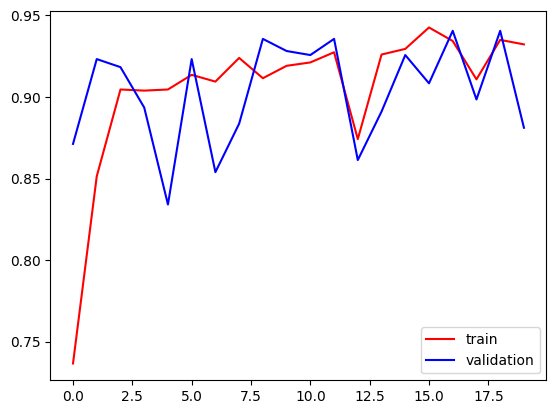

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

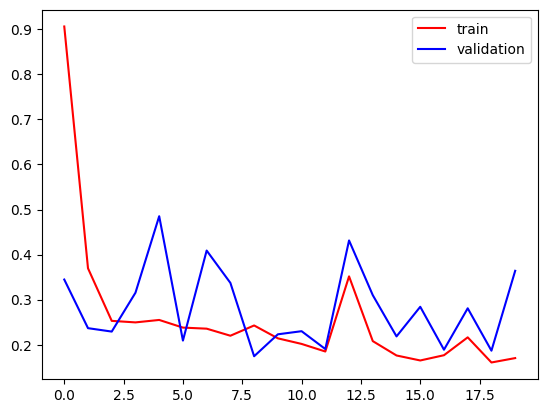

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model
loss, accuracy = ensemble_model.evaluate(validation_generator)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

13/13 [==============================] - 13s 954ms/step - loss: 0.3640 - accuracy: 0.8812
Test Loss: 0.3639826774597168
Test Accuracy: 0.8811880946159363
